In [27]:
import pandas as pd 
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import pickle

In [28]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
ros = RandomOverSampler(random_state = 42) #Balance the dataset
X_os, y_os = ros.fit_resample(df.iloc[:,1:], df.iloc[:,0])
X_os.insert(0,'owner',y_os)
df = X_os
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    print(i + ") mean: " + str(df[i].mean()) + ", std: " + str(df[i].std()))
    df[i] = (df[i]-df[i].mean())/df[i].std()
df

Age) mean: 10.527189265536723, std: 4.366565310455436
selling_price) mean: 463178.29996468924, std: 535345.0704025673
km_driven) mean: 70613.98181497175, std: 46726.0783381431


,owner,Age,selling_price,km_driven,fuel_Diesel,fuel_Other,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual
0,0,1.253345,-0.753119,-0.013140,False,False,True,False,True,False,False,True
1,0,1.253345,-0.613022,-0.441167,False,False,True,False,True,False,False,True
2,0,0.108280,0.255577,0.628900,True,False,False,False,True,False,False,True
3,0,-1.036785,-0.398207,-0.526772,False,False,True,False,True,False,False,True
4,1,-0.349746,-0.024616,1.506354,True,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1,1.024332,0.068781,1.784571,True,False,False,False,True,False,False,True
5660,1,0.795319,-0.622362,0.628900,True,False,False,False,True,False,False,True
5661,1,0.108280,-0.482267,-0.227153,False,False,True,True,False,False,False,True
5662,1,1.711370,-0.304810,-0.013140,False,False,True,False,True,False,False,True


# k-NN (Best Classifcation Model)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

In [30]:
knn = KNeighborsClassifier(n_neighbors=1) #k-NN model
grid = GridSearchCV(knn, param_grid = {'n_neighbors':list(range(1,1000,2))}, n_jobs = -1) #Perform grid search to tune hyperparameter k
grid.fit(X_train,y_train)
print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal Accuracy : ", grid.best_score_)

Optimal Hyper-parameters :  {'n_neighbors': 1}
Optimal Accuracy :  0.8214551525904724


In [31]:
Accuracy = {}
for i in range(1,1000,2): #Allow k to be odd to prevent ties #Compare accuracy among different k
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    Accuracy[i] = accuracy_score(y_test,y_pred)

In [32]:
k = np.array(list(Accuracy.keys())) #hyperparameter k
Acc = np.array(list(Accuracy.values())) #Corresponding Accuracy Values

[Text(0.5, 1.0, 'k-NN Accuracy Plot'),
 Text(0.5, 0, 'k'),
 Text(0, 0.5, 'Accuracy')]

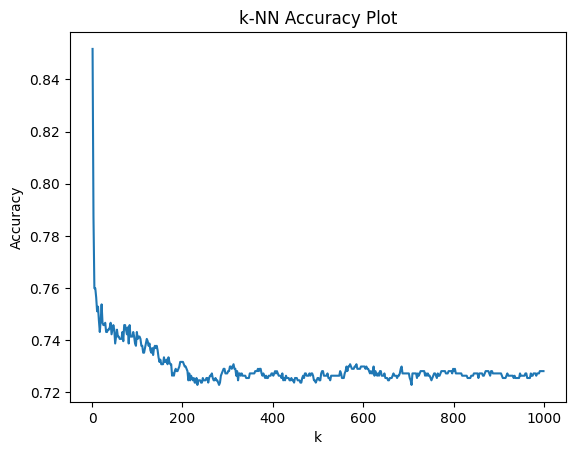

In [33]:
ax = sns.lineplot(x = k, y = Acc) #Visualize the values of k and their corresponding accuracy
ax.set(title = 'k-NN Accuracy Plot',xlabel = 'k',ylabel = 'Accuracy')

In [34]:
knn = KNeighborsClassifier(n_neighbors=1) #Model works best when k = 1 now fit the model
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       583
           1       0.81      0.92      0.86       550

    accuracy                           0.85      1133
   macro avg       0.86      0.85      0.85      1133
weighted avg       0.86      0.85      0.85      1133



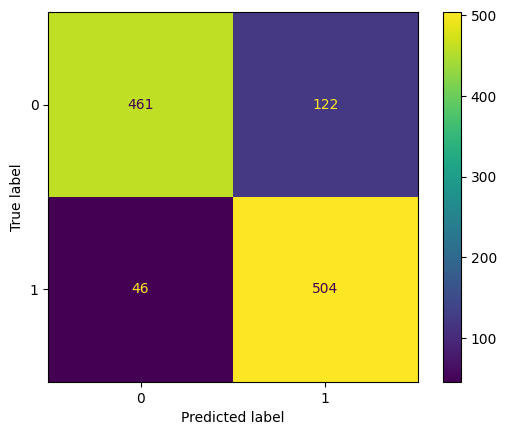

In [35]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
cm.plot()

In [36]:
CV = cross_validate(knn,df.iloc[:,1:], df.iloc[:,0], cv=10, scoring=['accuracy']) #Ensure model generalizes well by checking 10-fold CV
print('Accuracy')
print(CV['test_accuracy'])
print('Average Accuracy = ', sum(CV['test_accuracy']) / len(CV['test_accuracy']))

Accuracy
[0.82010582 0.83950617 0.83950617 0.79365079 0.78798587 0.91519435
 0.88162544 0.87632509 0.86219081 0.92226148]
Average Accuracy =  0.8538351998304885


In [37]:
pickle.dump(knn, open("models/Classification_knn.pkl", "wb"))

In [38]:
df.max(axis = 0)

owner                                   1
Age                              4.688539
selling_price                   15.759595
km_driven                       15.751055
fuel_Diesel                          True
fuel_Other                           True
fuel_Petrol                          True
seller_type_Dealer                   True
seller_type_Individual               True
seller_type_Trustmark Dealer         True
transmission_Automatic               True
transmission_Manual                  True
dtype: object

In [39]:
df.min(axis = 0)

owner                                  0
Age                            -1.723824
selling_price                  -0.827837
km_driven                      -1.511211
fuel_Diesel                        False
fuel_Other                         False
fuel_Petrol                        False
seller_type_Dealer                 False
seller_type_Individual             False
seller_type_Trustmark Dealer       False
transmission_Automatic             False
transmission_Manual                False
dtype: object

# Logistic Regression

In [40]:
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv') #Import raw data
df = df.set_index('name') #Index each observation by the Car Model
df['owner'] = df['owner'].apply(lambda x:0 if x == "First Owner" else 1).astype(int) # 0 means one previous owner (car is on the newer side)
# 1 means two or more previous owner and car is on the older side. This definition seems clear and more simplified
df['fuel'] = df['fuel'].apply(lambda x:'Petrol' if x == 'Petrol' else ('Diesel' if x == 'Diesel' else 'Other'))
#Simplify fuel types into 3 categories. Any fuel type that isn't petrol/diesel make up <10% of the dataset and should be lumped as other instead
df = pd.get_dummies(df, columns = ['fuel','seller_type','transmission']) #Make dummy variables for categorical variables so we can model with the data
df['year'] = 2023 - df['year'] #Transform year column into a variable representing a car's age
df.columns.values[0] = 'Age'
owner = df.pop('owner') #Move owner column to front
df.insert(0,'owner',owner)
ros = RandomOverSampler(random_state = 42) #Balance the dataset
X_os, y_os = ros.fit_resample(df.iloc[:,1:], df.iloc[:,0])
X_os.insert(0,'owner',y_os)
df = X_os
for i in ['Age','selling_price','km_driven']: #Standardize and scale these columns so k-NN will perform better
    print(i + ") mean: " + str(df[i].mean()) + ", std: " + str(df[i].std()))
    df[i] = (df[i]-df[i].mean())/df[i].std()
print(df)
df = df.drop(columns = ['transmission_Automatic','seller_type_Dealer','fuel_Other']) #Drop some dummy variables so we
#have k - 1 variables for k levels and to prevent Singularity Issues

Age) mean: 10.527189265536723, std: 4.366565310455436
selling_price) mean: 463178.29996468924, std: 535345.0704025673
km_driven) mean: 70613.98181497175, std: 46726.0783381431
      owner       Age  selling_price  km_driven  fuel_Diesel  fuel_Other   
0         0  1.253345      -0.753119  -0.013140        False       False  \
1         0  1.253345      -0.613022  -0.441167        False       False   
2         0  0.108280       0.255577   0.628900         True       False   
3         0 -1.036785      -0.398207  -0.526772        False       False   
4         1 -0.349746      -0.024616   1.506354         True       False   
...     ...       ...            ...        ...          ...         ...   
5659      1  1.024332       0.068781   1.784571         True       False   
5660      1  0.795319      -0.622362   0.628900         True       False   
5661      1  0.108280      -0.482267  -0.227153        False       False   
5662      1  1.711370      -0.304810  -0.013140        False    

In [41]:
df

,owner,Age,selling_price,km_driven,fuel_Diesel,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,0,1.253345,-0.753119,-0.013140,False,True,True,False,True
1,0,1.253345,-0.613022,-0.441167,False,True,True,False,True
2,0,0.108280,0.255577,0.628900,True,False,True,False,True
3,0,-1.036785,-0.398207,-0.526772,False,True,True,False,True
4,1,-0.349746,-0.024616,1.506354,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...
5659,1,1.024332,0.068781,1.784571,True,False,True,False,True
5660,1,0.795319,-0.622362,0.628900,True,False,True,False,True
5661,1,0.108280,-0.482267,-0.227153,False,True,False,False,True
5662,1,1.711370,-0.304810,-0.013140,False,True,True,False,True


In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size = .2, random_state = 0) #Split dataset

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       583
           1       0.71      0.74      0.73       550

    accuracy                           0.73      1133
   macro avg       0.73      0.73      0.73      1133
weighted avg       0.73      0.73      0.73      1133



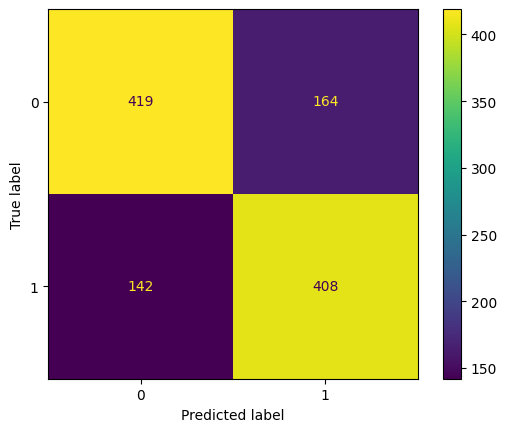

In [43]:
logreg = LogisticRegression() #Fit a logistic regression with default threshold
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

In [44]:
y_pred = logreg.predict_proba(X_test) 
y_pred = y_pred[::,1]#Extract sigmoid probabilities
fpr, tpr, _ = roc_curve(y_test,  y_pred) #Calculate fpr and tpr for each threshold to make roc curve
auc = roc_auc_score(y_test, y_pred) #Get AUC to evaulate model
auc #AUC of roughly .8 Model performs fairly well

0.7830765632309372

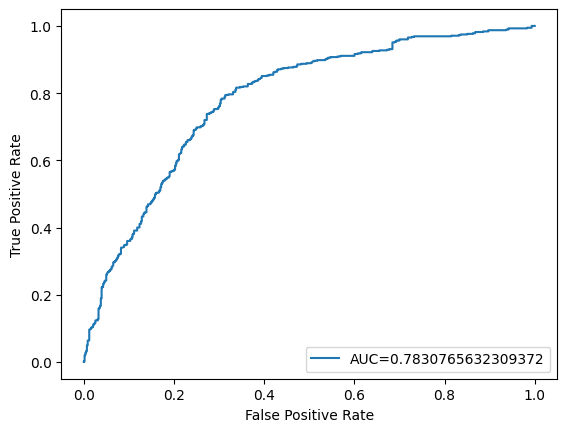

In [45]:
plt.plot(fpr,tpr,label="AUC="+str(auc)) #Plot ROC curve
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [46]:
optimal_idx = np.argmax(tpr - fpr) #Find the optimal threshold
optimal_threshold = _[optimal_idx]
optimal_threshold

0.4632854322437184

In [47]:
y_pred = (y_pred > optimal_threshold).astype(int) #Compare probabilites to optimal threshold for classification

In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       583
           1       0.70      0.79      0.75       550

    accuracy                           0.74      1133
   macro avg       0.74      0.74      0.74      1133
weighted avg       0.74      0.74      0.74      1133



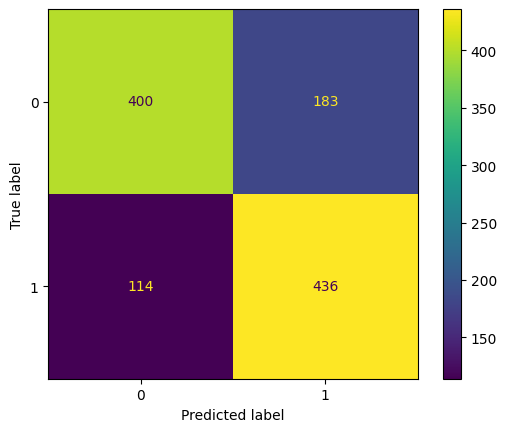

In [49]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)) #Make Confusion Matrix
cm.plot()

The optimal threshold is close to .5 so for simplicity sake, let's implement the built in .5 threshold model.

In [50]:
pickle.dump(logreg, open("models/Classification_LogReg.pkl", "wb"))